This notebook shows the process of income prediction based on ADULT dataset when fairness through unawareness approach is applied. This means that only the protected attributes are removed from the dataset.

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In the following there's the import of the dataset and the preliminary work in order to fix the attributes, fill the NaN values and finally make the dataset ready for the analytics job

In [3]:
adult_dataset = pd.read_csv('./adult.data', sep=',')

In [4]:
adult_dataset

age         workclass  fnlwgt   education  education-num  \
0       39         State-gov   77516   Bachelors             13   
1       50  Self-emp-not-inc   83311   Bachelors             13   
2       38           Private  215646     HS-grad              9   
3       53           Private  234721        11th              7   
4       28           Private  338409   Bachelors             13   
...    ...               ...     ...         ...            ...   
32556   27           Private  257302  Assoc-acdm             12   
32557   40           Private  154374     HS-grad              9   
32558   58           Private  151910     HS-grad              9   
32559   22           Private  201490     HS-grad              9   
32560   52      Self-emp-inc  287927     HS-grad              9   

           marital-status         occupation   relationship   race     sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  White    Male   
2                Divorced  Handlers-cleaners  Not-in-family  White    Male   
3      Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4      Married-civ-spouse     Prof-specialty           Wife  Black  Female   
...                   ...                ...            ...    ...     ...   
32556  Married-civ-spouse       Tech-support           Wife  White  Female   
32557  Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
32558             Widowed       Adm-clerical      Unmarried  White  Female   
32559       Never-married       Adm-clerical      Own-child  White    Male   
32560  Married-civ-spouse    Exec-managerial           Wife  White  Female   

       capital-gain  capital-loss  hours-per-week native-country income  
0              2174             0              40  United-States  <=50K  
1                 0             0              13  United-States  <=50K  
2                 0             0              40  United-States  <=50K  
3                 0             0              40  United-States  <=50K  
4                 0             0              40           Cuba  <=50K  
...             ...           ...             ...            ...    ...  
32556             0             0              38  United-States  <=50K  
32557             0             0              40  United-States   >50K  
32558             0             0              40  United-States  <=50K  
32559             0             0              20  United-States  <=50K  
32560         15024             0              40  United-States   >50K  

[32561 rows x 15 columns]

In [5]:
from fairness.pre_processing import categorical_to_numeric_converter, fix_attributes


new_adult_dataset = categorical_to_numeric_converter(adult_dataset)

In [6]:
new_adult_dataset = fix_attributes(new_adult_dataset, ['race', 'fnlwgt', 'capital-gain', 'capital-loss'])

In [7]:
new_adult_dataset

age  workclass  fnlwgt  education  education-num  marital-status  \
0       39          7       0          9             13               4   
1       50          6       0          9             13               2   
2       38          4       1         11              9               0   
3       53          4       1          1              7               2   
4       28          4       1          9             13               2   
...    ...        ...     ...        ...            ...             ...   
32556   27          4       1          7             12               2   
32557   40          4       0         11              9               2   
32558   58          4       0         11              9               6   
32559   22          4       1         11              9               4   
32560   52          5       1         11              9               2   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
0               1             1     1    1             1             0   
1               4             0     1    1             0             0   
2               6             1     1    1             0             0   
3               6             0     0    1             0             0   
4              10             5     0    0             0             0   
...           ...           ...   ...  ...           ...           ...   
32556          13             5     1    0             0             0   
32557           7             0     1    1             0             0   
32558           1             4     1    0             0             0   
32559           1             3     1    1             0             0   
32560           4             5     1    0             1             0   

       hours-per-week  native-country  income  
0                  40              39       0  
1                  13              39       0  
2                  40              39       0  
3                  40              39       0  
4                  40               5       0  
...               ...             ...     ...  
32556              38              39       0  
32557              40              39       1  
32558              40              39       0  
32559              20              39       0  
32560              40              39       1  

[32561 rows x 15 columns]

At this point there's the protected attributes removal from the dataset. In this case we have chosen the following variables to be protected, according to the domain of the dataset:
* race
* sex
* native-country

In [8]:
protected_attributes = ['race', 'sex', 'native-country']

In [9]:
new_adult_dataset.drop(columns=protected_attributes, inplace=True)

After the pre-processing step and after the protected attributes removal it's important to move to the training and prediction step

In [10]:
from sklearn.model_selection import train_test_split

X = new_adult_dataset.drop(columns=['income'], inplace=False)
y = new_adult_dataset['income']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

After the split of the dataset, the next step is to perform the calculations of the best parameters for the several models we want to use for the prediction step.

In this case we choose the following models: 
* RandomForest Classifier
* Logistic Regression
* DecisionTree Classifier

The best params for the RandomForest Classifier are:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 40, 'n_estimators': 70}


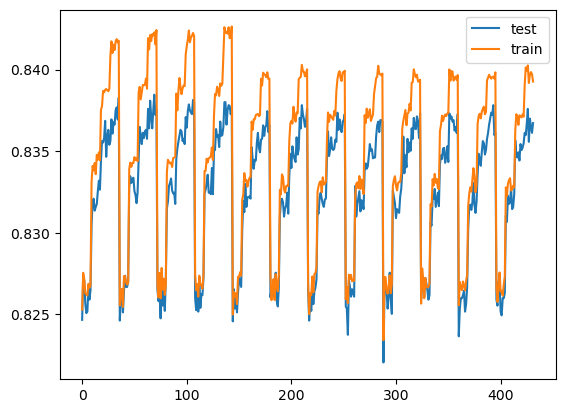

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest_model = RandomForestClassifier()
random_forest_params = {'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(random_forest_model, param_grid=random_forest_params, cv=10, return_train_score=True)
random_forest = grid_search.fit(X_train, y_train)

print("The best params for the RandomForest Classifier are: ", random_forest.best_params_)

test_scores = random_forest.cv_results_['mean_test_score']
train_scores = random_forest.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for random_forest:  0.8402196166015261


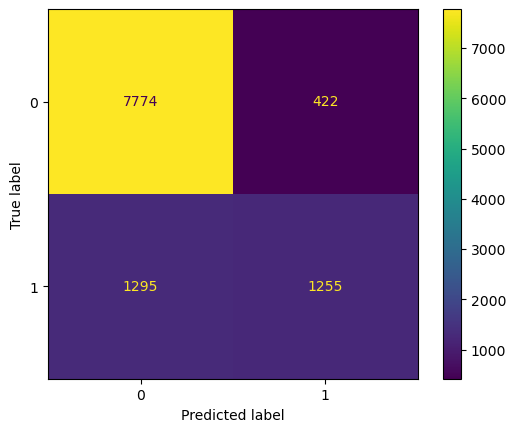

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predicted_result = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for random_forest: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=random_forest.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=random_forest.classes_)
display.plot()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

The best params for the Logistic Regression:  {'penalty': 'l1', 'solver': 'liblinear'}


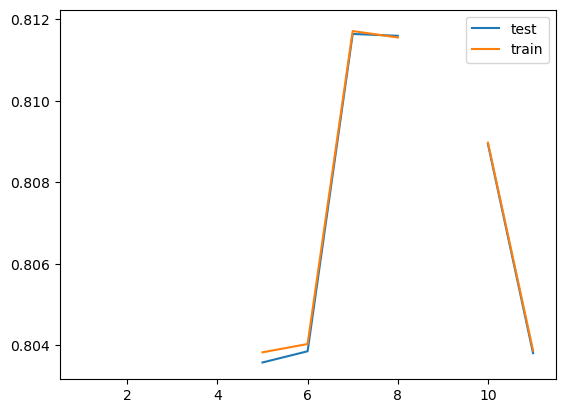

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_regression_model = LogisticRegression()
logistic_regression_params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_search = GridSearchCV(logistic_regression_model, param_grid=logistic_regression_params, cv=10, return_train_score=True)
logistic_regression = grid_search.fit(X_train, y_train)

print("The best params for the Logistic Regression: ", logistic_regression.best_params_)

test_scores = logistic_regression.cv_results_['mean_test_score']
train_scores = logistic_regression.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for logistic regression:  0.8164898566908617


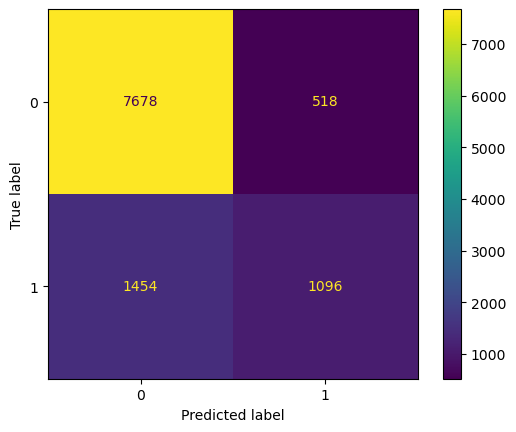

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for logistic regression: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=logistic_regression.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=logistic_regression.classes_)
display.plot()
plt.show()

The best params for DecisionTree Classifier are:  {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 40}


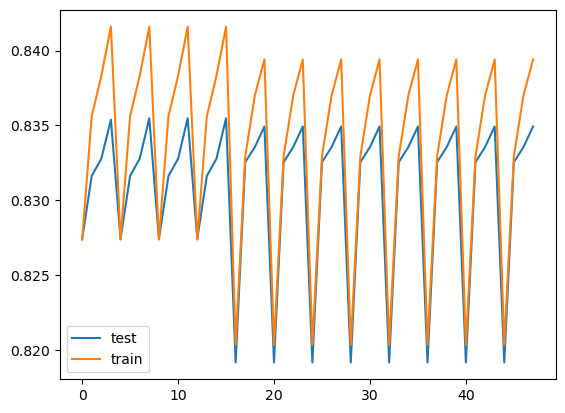

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree_model = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(decision_tree_model, param_grid=decision_tree_params, cv=10, return_train_score=True)
decision_tree = grid_search.fit(X_train, y_train)
best_params = decision_tree.best_params_
print("The best params for DecisionTree Classifier are: ", best_params)

test_scores = decision_tree.cv_results_['mean_test_score']
train_scores = decision_tree.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for decision tree classifier:  0.8376139959054532


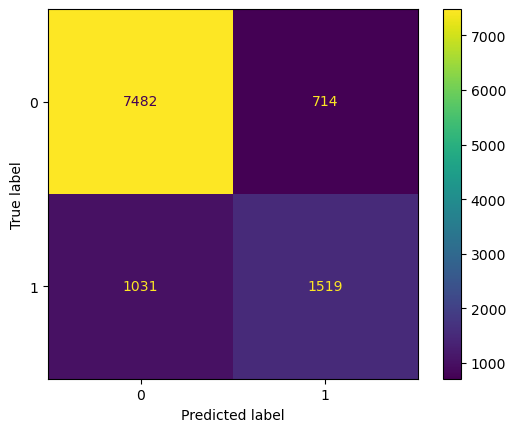

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for decision tree classifier: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=decision_tree.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=decision_tree.classes_)
display.plot()
plt.show()